# DISCLAIMER!
The data is fetched from https://github.com/pcm-dpc/COVID-19/ and they are provided from italian civil protection. The forecast models represents a simplification of the reality, and they do not pretend to have scientific validity (references in bottom). Accordingly to the documentation (https://github.com/pcm-dpc/COVID-19/wiki/1.it-Dati:-andamento-nazionale), the number of total cases, hospitalizations and intensive care is not cumulative, i.e. the number represents the people that are currently positive or in hospital/intensive care units. The data of the population comes from ISTAT open data (http://dati.istat.it).

In [1]:
from func import plotCurve

# Plots

## Total cases

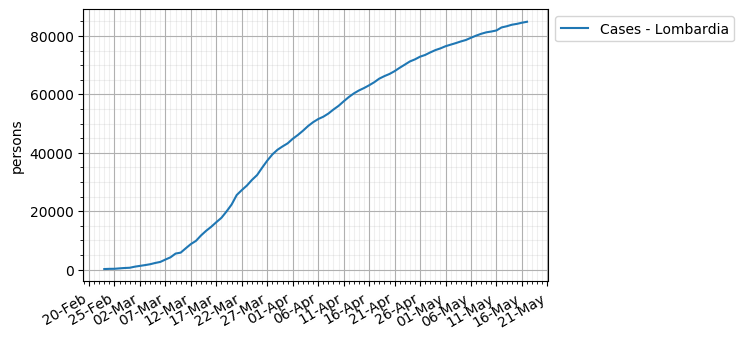

In [2]:
plotCurve('Total cases', 'Lombardia')

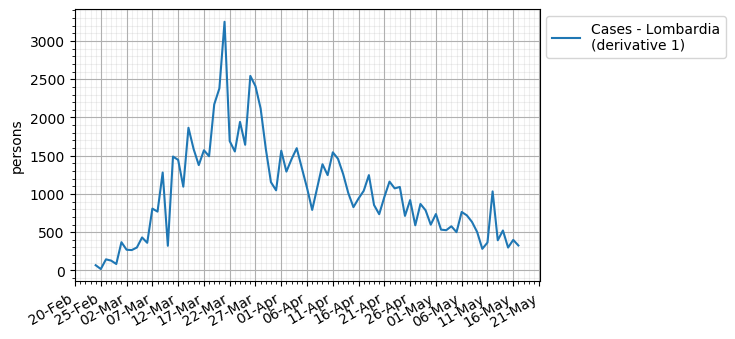

In [3]:
plotCurve('Total cases', 'Lombardia', derivative=1)

---

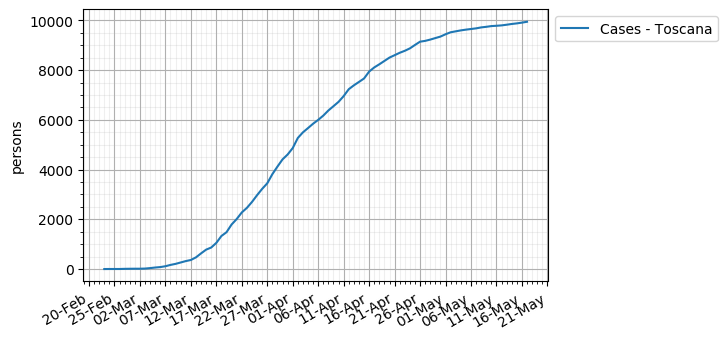

In [4]:
plotCurve('Total cases', 'Toscana')

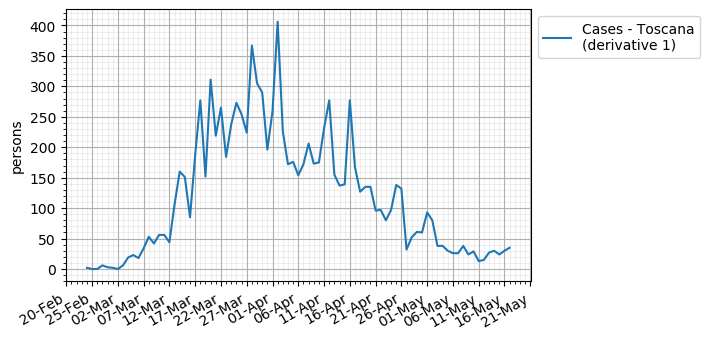

In [5]:
plotCurve('Total cases', 'Toscana', derivative=1)

---

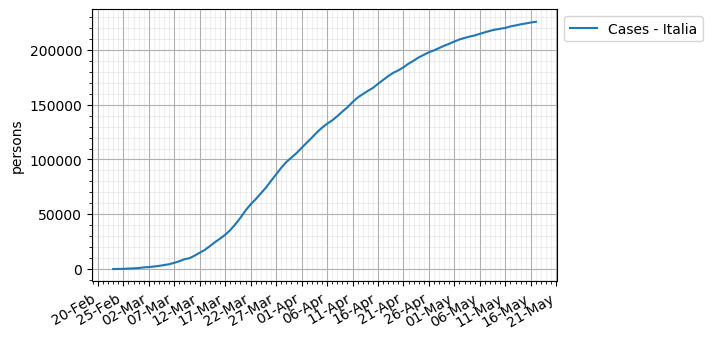

In [6]:
plotCurve('Total cases')

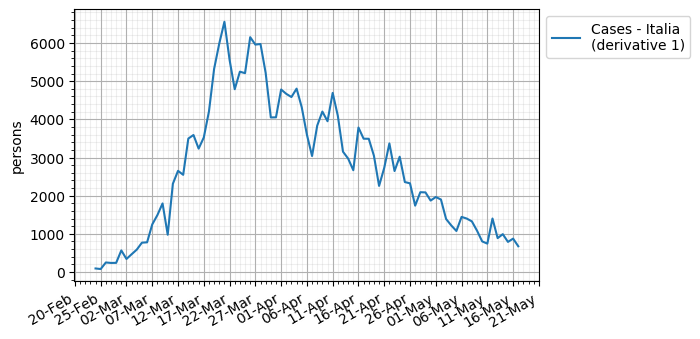

In [7]:
plotCurve('Total cases', derivative=1)

---

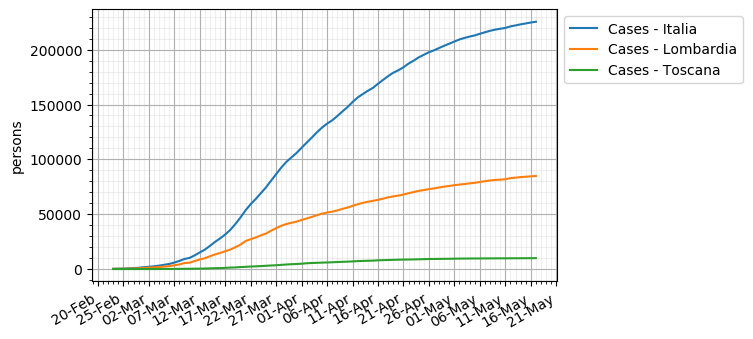

In [8]:
plotCurve('Total cases', ['Italia','Lombardia','Toscana'])

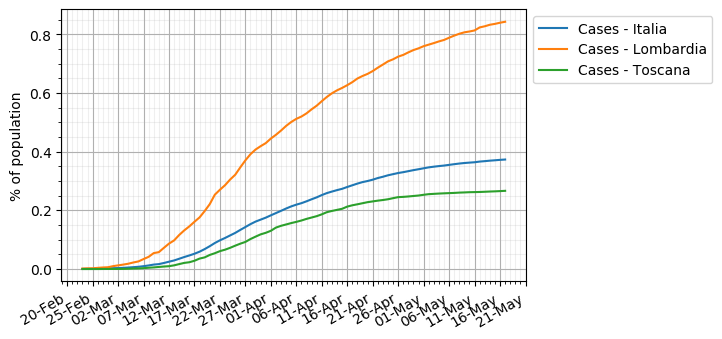

In [9]:
plotCurve('Total cases', ['Italia','Lombardia','Toscana'], normalize='population')

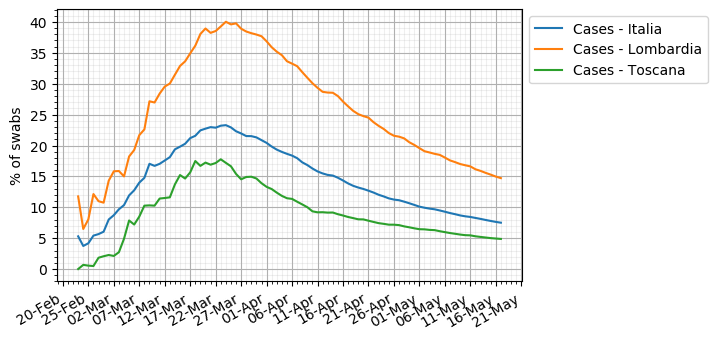

In [10]:
plotCurve('Total cases', ['Italia','Lombardia','Toscana'], normalize='swabs')

## Hospitalizations

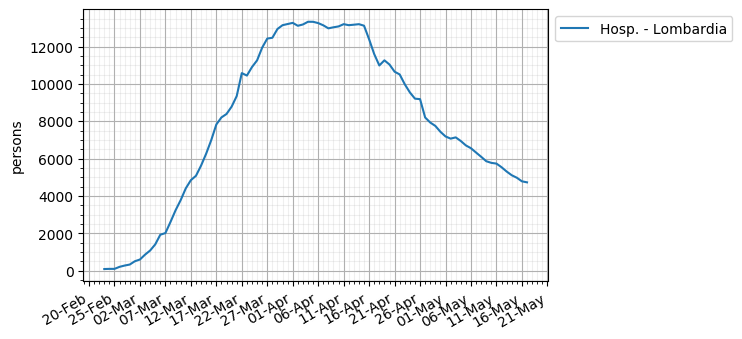

In [11]:
plotCurve('Hospitalizations', 'Lombardia')

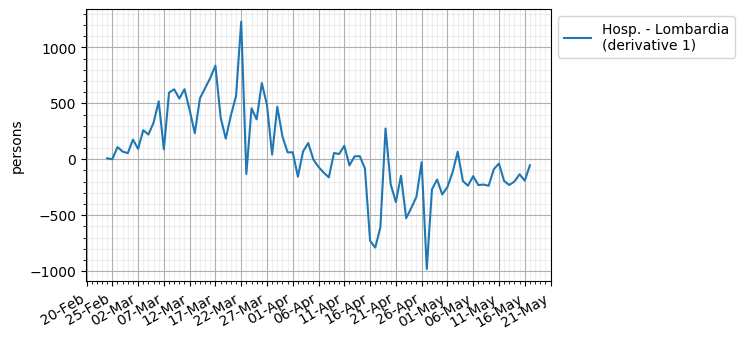

In [12]:
plotCurve('Hospitalizations', 'Lombardia', derivative=1)

---

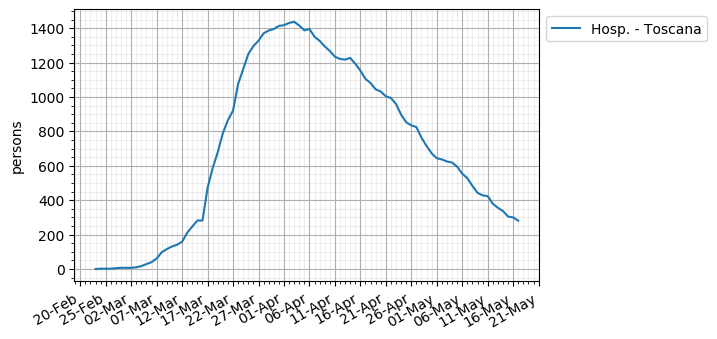

In [13]:
plotCurve('Hospitalizations', 'Toscana')

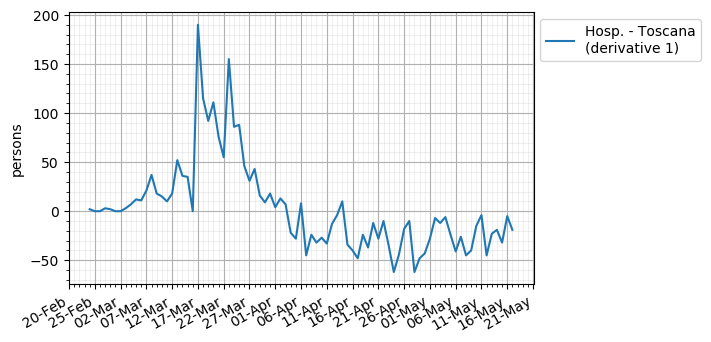

In [14]:
plotCurve('Hospitalizations', 'Toscana', derivative=1)

---

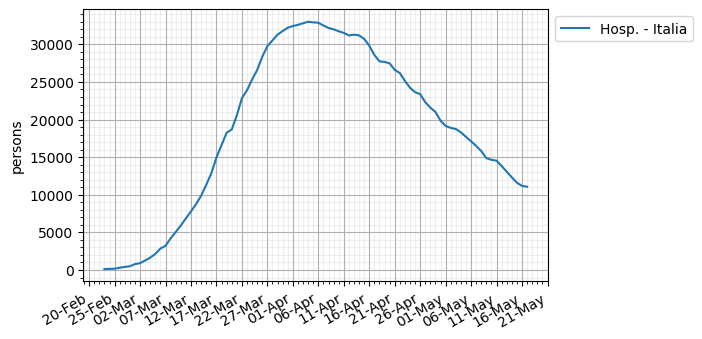

In [15]:
plotCurve('Hospitalizations')

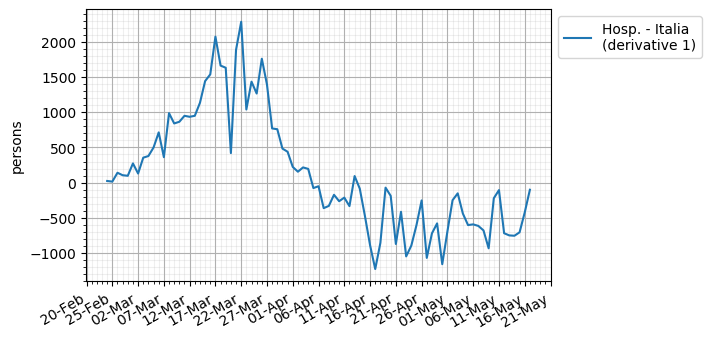

In [16]:
plotCurve('Hospitalizations', derivative=1)

---

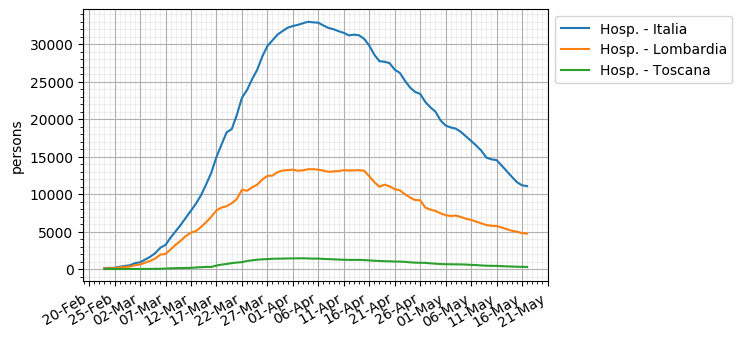

In [17]:
plotCurve('Hospitalizations', ['Italia','Lombardia','Toscana'])

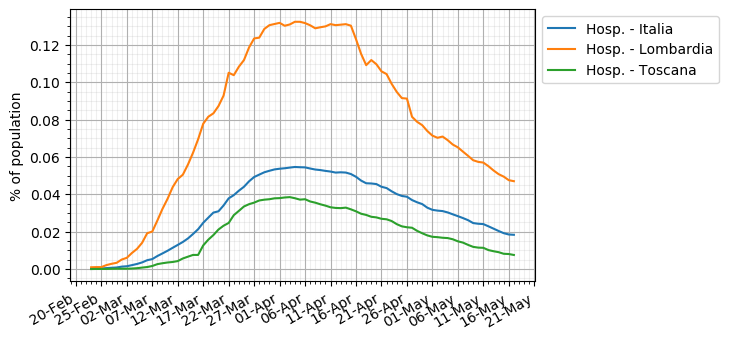

In [18]:
plotCurve('Hospitalizations', ['Italia','Lombardia','Toscana'], normalize='population')

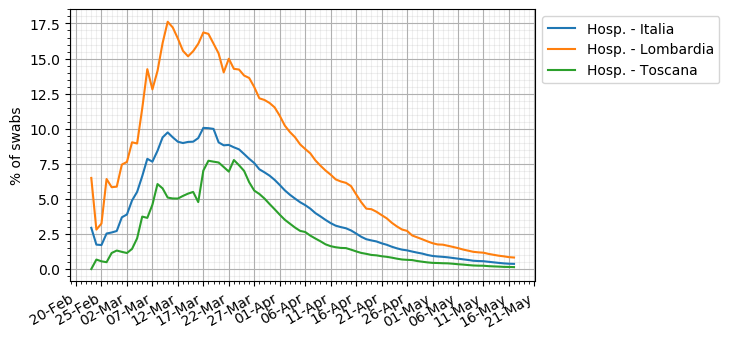

In [19]:
plotCurve('Hospitalizations', ['Italia','Lombardia','Toscana'], normalize='swabs')

## Intensive care

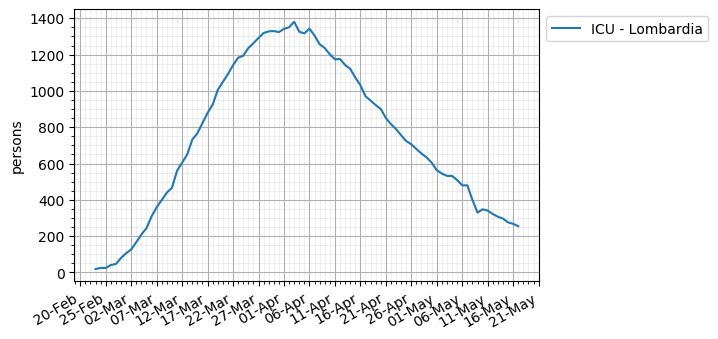

In [20]:
plotCurve('Intensive care', 'Lombardia')

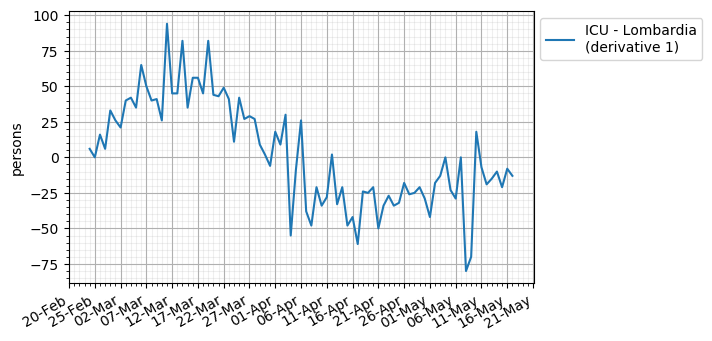

In [21]:
plotCurve('Intensive care', 'Lombardia', derivative=1)

---

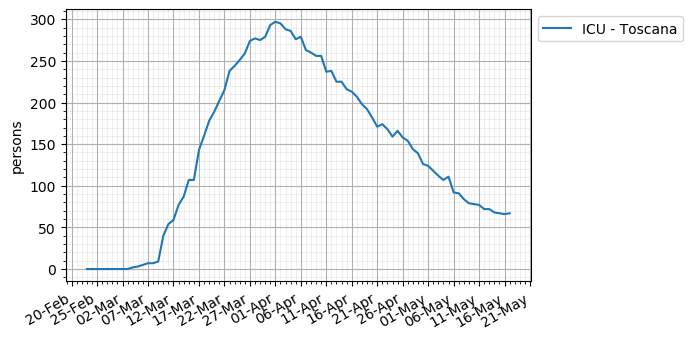

In [22]:
plotCurve('Intensive care', 'Toscana')

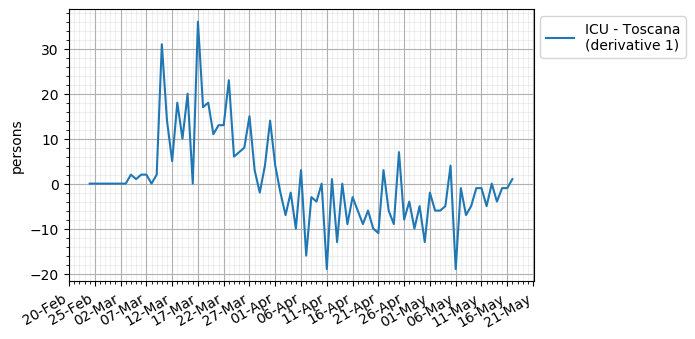

In [23]:
plotCurve('Intensive care', 'Toscana', derivative=1)

---

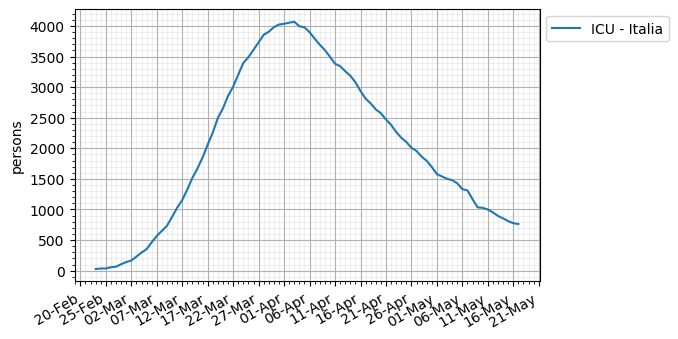

In [24]:
plotCurve('Intensive care')

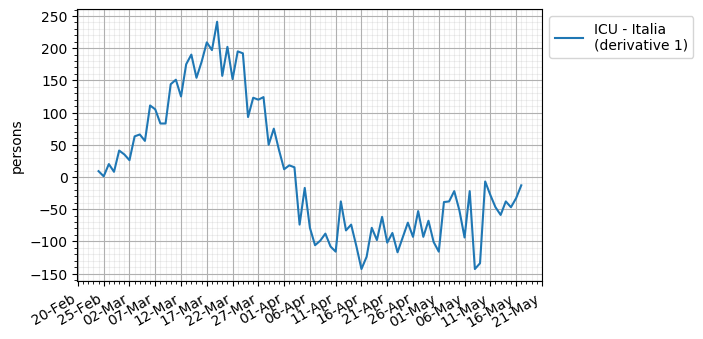

In [25]:
plotCurve('Intensive care', derivative=1)

---

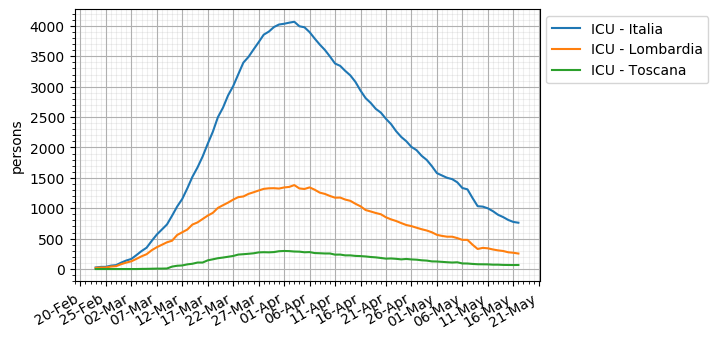

In [26]:
plotCurve('Intensive care', ['Italia','Lombardia','Toscana'])

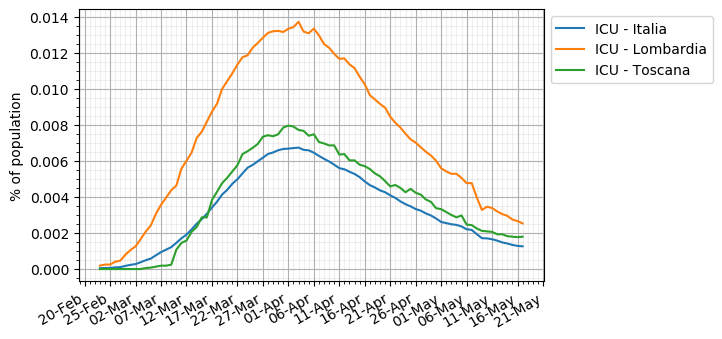

In [27]:
plotCurve('Intensive care', ['Italia','Lombardia','Toscana'], normalize='population')

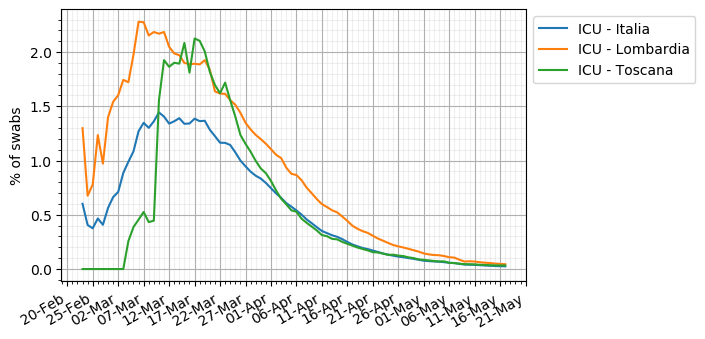

In [28]:
plotCurve('Intensive care', ['Italia','Lombardia','Toscana'], normalize='swabs')

## Deceased

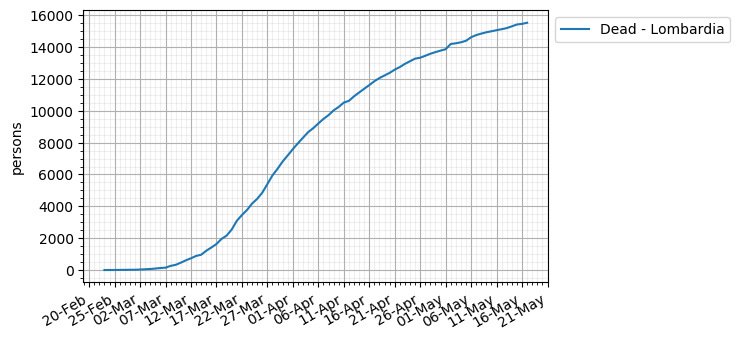

In [29]:
plotCurve('Deceased', 'Lombardia')

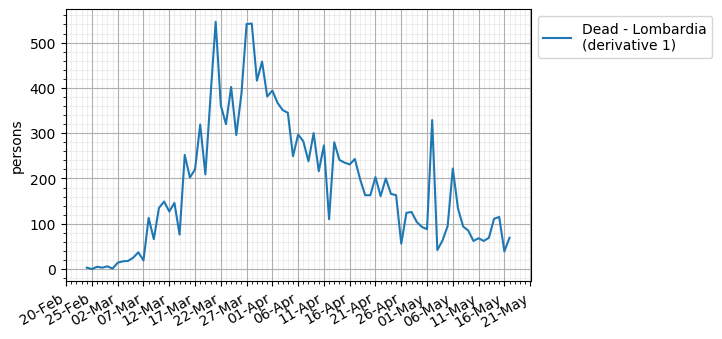

In [30]:
plotCurve('Deceased', 'Lombardia', derivative=1)

---

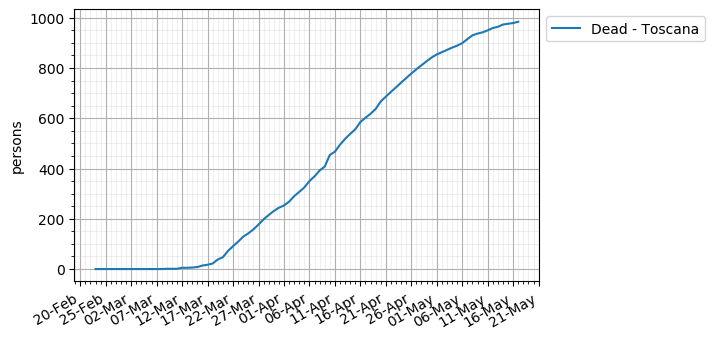

In [31]:
plotCurve('Deceased', 'Toscana')

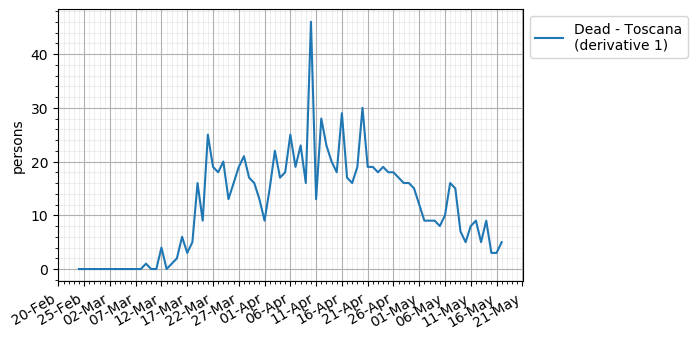

In [32]:
plotCurve('Deceased', 'Toscana', derivative=1)

---

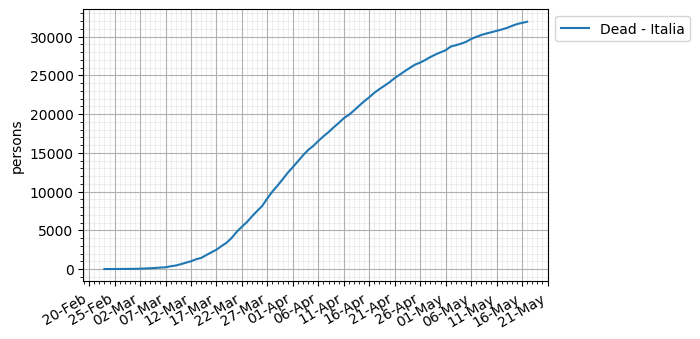

In [33]:
plotCurve('Deceased')

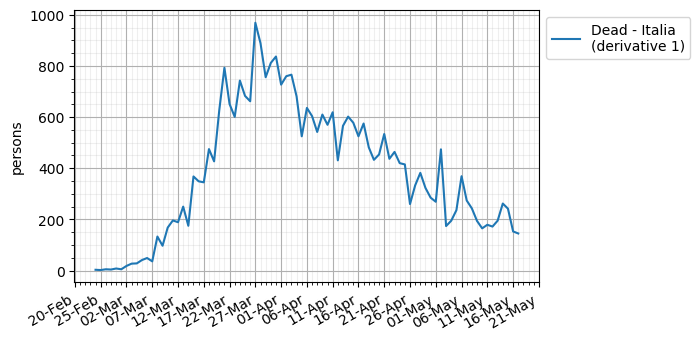

In [34]:
plotCurve('Deceased', derivative=1)

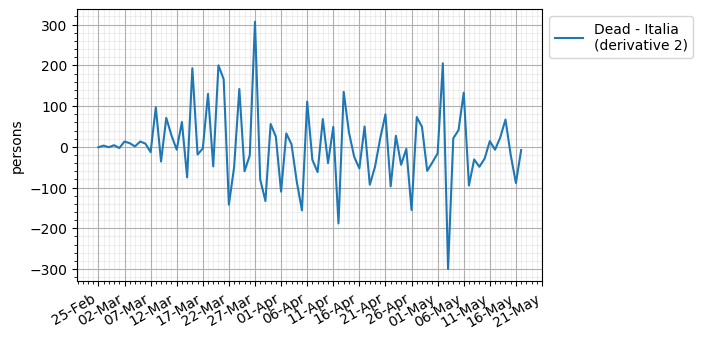

In [35]:
plotCurve('Deceased', derivative=2)

---

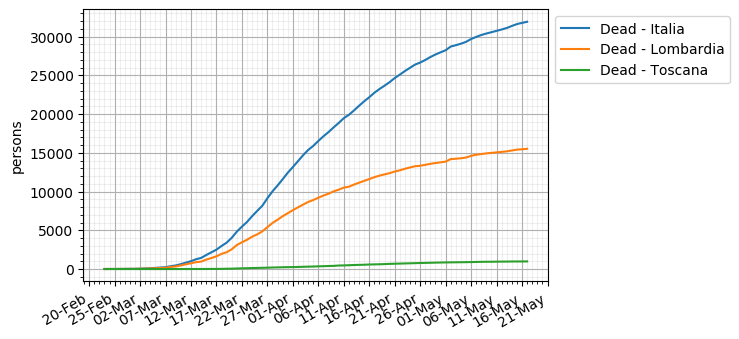

In [36]:
plotCurve('Deceased', ['Italia','Lombardia','Toscana'])

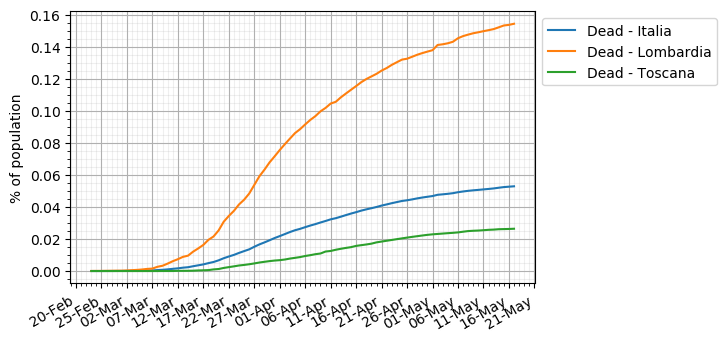

In [37]:
plotCurve('Deceased', ['Italia','Lombardia','Toscana'], normalize='population')

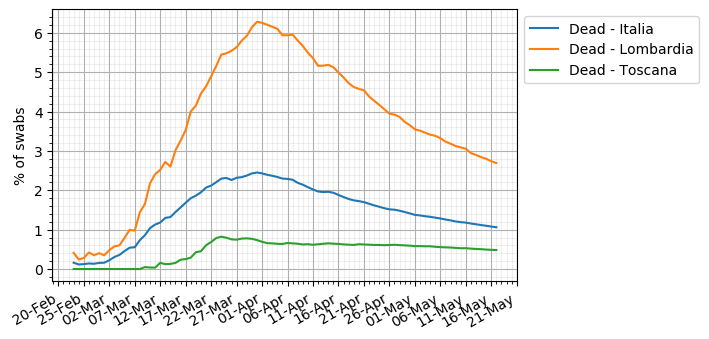

In [38]:
plotCurve('Deceased', ['Italia','Lombardia','Toscana'], normalize='swabs')

# Compare

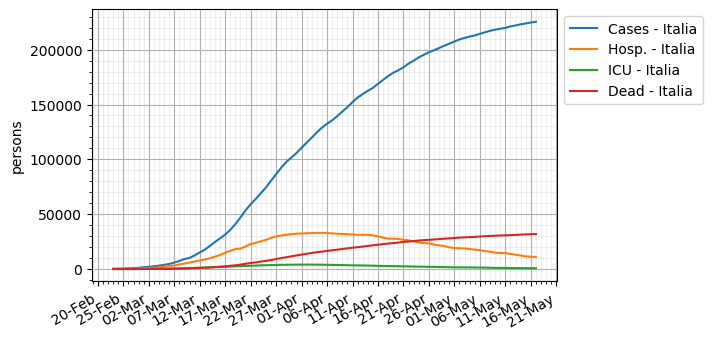

In [39]:
plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Italia')

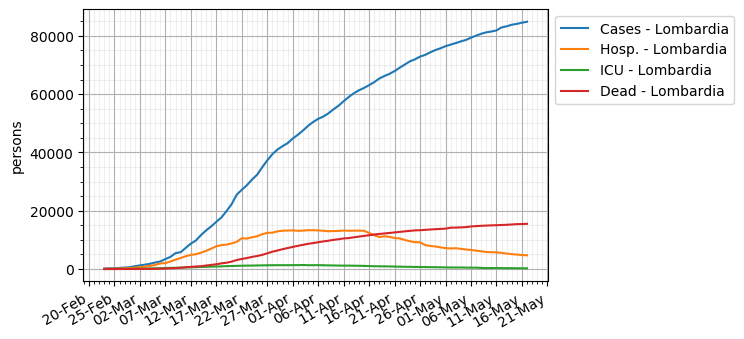

In [40]:
plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Lombardia')

In [41]:
#plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Emilia Romagna')

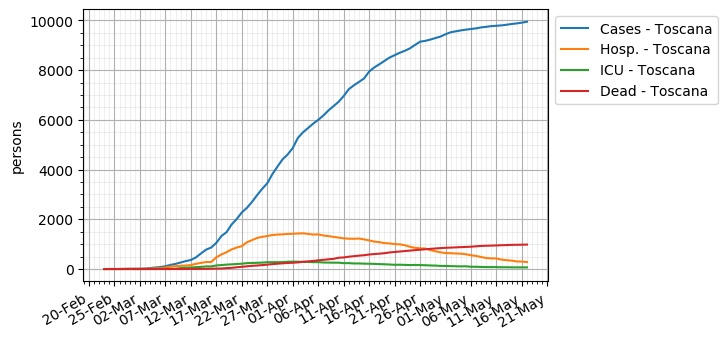

In [42]:
plotCurve(['Total cases','Hospitalizations','Intensive care','Deceased'], 'Toscana')

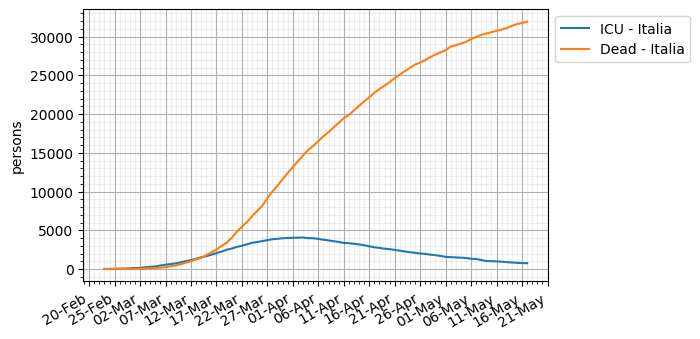

In [43]:
plotCurve(['Intensive care','Deceased'], 'Italia')

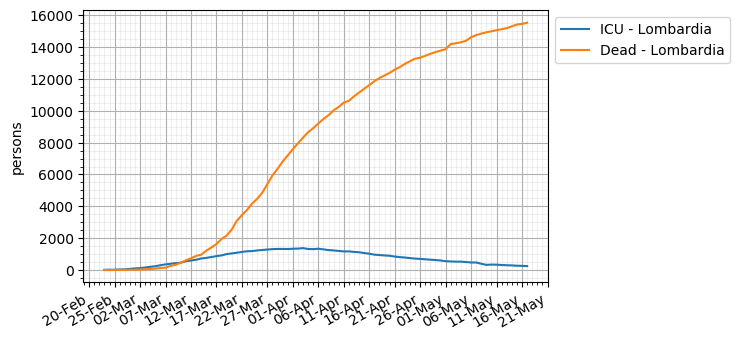

In [44]:
plotCurve(['Intensive care','Deceased'], 'Lombardia')

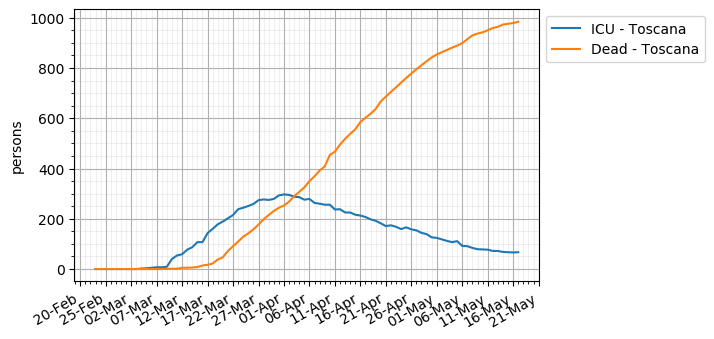

In [45]:
plotCurve(['Intensive care','Deceased'], 'Toscana')

### References
* https://colab.research.google.com/drive/1EprvUCsrqeJOeuXHuQfY_iiO4Dw8NH5q?fbclid=IwAR0j2KjgX9ffrys4P0su036gmYSvDMAuCuwCUd1vNN7qlwmQvX8r0ZdpUpc#scrollTo=nZKHXDxcfegX
* https://avatorl.org/covid-19/?page=GrowthRateAndForecast
* http://opendatadpc.maps.arcgis.com/apps/opsdashboard/index.html#/b0c68bce2cce478eaac82fe38d4138b1
* https://github.com/pcm-dpc/COVID-19/
* https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be
* https://doi.org/10.1101/2020.02.16.20023606